## INDIVIDUAL HOUSEHOLD ELECTRIC POWER DATA SET

## https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [26]:
# Loadind the Data
#obs: for Big Data packages, pandas could not be the best option
#spark is more recommended for Big Data
# we use low_memory to allow the bert performance memory
data = pd.read_csv("household_power_consumption.txt", delimiter = ';', low_memory = False)

In [27]:
#The 'dropna' delete the NA's registers, in this case is not interesting to replace the NA's  using the avearage
#beacause the NA's percent is about 1.25% of data and the dataset has more than 2.000.000 observations
power_consumption = data.iloc[0:, 2:9].dropna()

In [28]:
#The prerequisite for the application of k-means is that the entire database 
#to be used is in numerical form, for this purpose follows a small sample of this verification.
#Otherwise, we must to convert the dataset for a numeric format 
power_consumption.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [29]:
# get attributes and split into training and test datasets
pc_toarray = power_consumption.values
df_train, df_test= train_test_split(pc_toarray, train_size =.01)

In [30]:
#Applies dimensionality reduction, we are not reducing the numbers of variables
#we only collected all variances from the variables and input it in 2 components
#and these components represents the same variables information 
#so now we can work with only these 2 components to make predictions
hpc = PCA(n_components = 2).fit_transform(df_train)

In [31]:
# Building the model
#now we apply the fit in the object calls hpc which was transformed before, with the reduced dimiensionality 
k_means = KMeans()
k_means.fit(hpc)
# how we did not choose the paramenters for k, the k_means() chose n_cluster=8 as a default, how we can see bellow

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
# Now we are going to organize the data to get minimum and maximum values and arrange shape
# to plot it and to build the graphic
x_min, x_max = hpc[:, 0].min() - 5, hpc[:, 0].max() - 1
y_min, y_max = hpc[:, 1].min(), hpc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

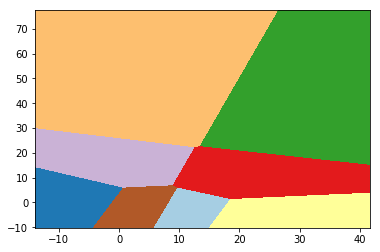

In [33]:
# Area Clusters Plot
# how k_means is working with k = 8, so the graphic show us 8 areas inside the plot 
# the plot contain 8 vohoronov celuls 
#Each color area represent a cluster area
plt.figure(1)
plt.clf()
plt.imshow(z,
          interpolation = 'nearest',
          extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired, 
           aspect = 'auto',
           origin = 'lower')


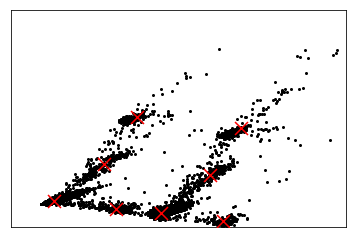

In [34]:
# Plot of each centroids clusters
# the centroid or geometric center of a flat figure is the arithmetic mean posição of all points in the figure
#The red X represent the 8 centroids clusters
# we have some distant points that could not be identified 
#it is not a clustering mistake, but show us that these points do not have similarities with the other groups
# could be out liers, wrong data inserted to dataset
# so in this case you should to discuss about it with the business area to be sure why
# these points are differents
plt.plot(hpc[:, 0], hpc[:, 1], 'k.' , markersize = 4)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x' , s = 169, linewidths = 3, color ='r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [35]:
#Determining a range for K
# In this specific case is possible to run this process
# In a big data case it would be hard to process it 
k_range = range(1, 14)

In [36]:
#Appling K-Means model for each K value to see the different results
# and identify the best k value using a list comprehension, running in one command we can run different operations
# this code is creating a model and fitting it for each k value inside of the range
k_means_var = [KMeans(n_clusters = k).fit(hpc) for k in k_range]

In [37]:
# Adjusting the centroids cluster for each model
#In this code we are using another list comprehension and for each model 
# with different k values, we are colecting the centroids
#This is a bennefit to use code, because when you use some interface
#Although the visual interface is easier to manipulate, you do not have differents options to improve your results as the code
centroids = [X.cluster_centers_ for X in k_means_var]

In [38]:
#Calculating the Euclidean distance for each value in my centroids list calclulated before
#Euclidean distance (or metric distance ) is the distance between two points,
#which can be proved by repeated application of the Pythagorean theorem 
k_euclid = [cdist(hpc, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

In [39]:
#Sum of the squares of distances inside of cluster
wcss = [sum(d**2) for d in dist]

In [40]:
# Total Sum of the squares
tss = sum(pdist(hpc)**2)/hpc.shape[0]

In [42]:
#Total Sum of the Squares - Sum of the Squares of distances inside of clusters
bss = tss - wcss

Text(0.5,1,'Explicated Variance x K Value')

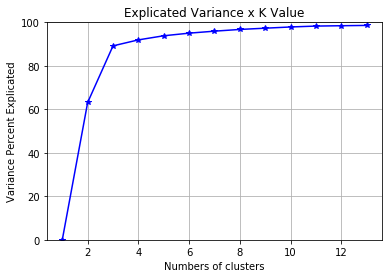

In [43]:
# Elbow Curv
# So now we can calculate the variance resulted from  
#Total Sum of the Squares - Sum of the Squares of distances inside of clusters
# with this result we know that for each k value we can understand the variance value
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Numbers of clusters')
plt.ylabel('Variance Percent Explicated')
plt.title('Explicated Variance x K Value')

In [44]:
# Creating a new model with k = 7 clusters
k_means = KMeans(n_clusters = 7)
k_means.fit(hpc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [45]:
# Get the Minimum and Maximum Value and arrange the Shape
x_min, x_max = hpc[:, 0].min() - 5, hpc[:, 0].max() - 1
y_min, y_max = hpc[:, 1].min(), hpc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

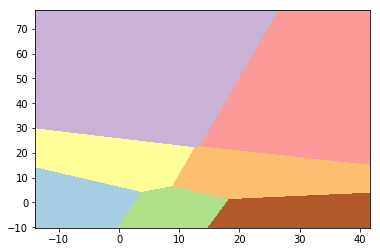

In [46]:
# Area Clusters Plot
plt.figure(1)
plt.clf()
plt.imshow(z,
          interpolation = 'nearest',
          extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired, 
           aspect = 'auto',
           origin = 'lower')


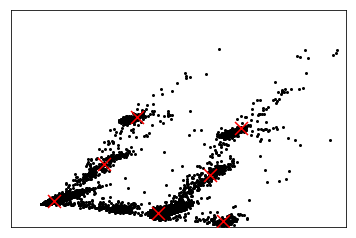

In [47]:
# Plot of each centroids clusters

plt.plot(hpc[:, 0], hpc[:, 1], 'k.' , markersize = 4)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x' , s = 169, linewidths = 3, color ='r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#There was not much difference in outcome between the 7 and 8 cluster models. 
#Therefore, the cluster number is not always the most important in the clustering process,
#but rather the interpretation collected from the model result. 
#Therefore, in-depth knowledge of the data and the business problem becomes important,
#as the application of the clustering model becomes the fastest part
#and the other parts of the process are those that require the most time
#and attention to get the best results.

In [23]:
?silhouette_score

#The best value is 1 and the worst value is -1. 
#Values close to 0 indicate overlapping clusters, meaning that they belong to more than one cluster.
#Negative values usually indicate that a sample was assigned to the wrong cluster
#because a different cluster is more similar.

In [48]:
# Silhouette_score
labels = k_means.labels_
silhouette_score(hpc, labels, metric = 'euclidean')

0.8431988595262061

# END